# Anomaly detection: Milestone #4

**Kyle Honegger (CSCIE-109A)**

**Abhaydeep Singh (STAT121)**

## Anomaly detection task

Our goal is to create a web application that detects anomalous points in a continuous data stream, in real time, without any form of supervised learning. Several characteristics are desirable for this application, including:

* Tunable sensitivity (biasing toward sensitivity vs. specificity)
* Dead-reckoning (unsupervised) detection ability
* Fast, real time processing with low computational overhead
* Low-latency to event detection (recognize anomalies quickly as they happen)

To address these various desiderata, we have developed an on-line anomaly detection platform using plug-in martingales to test the exchangeability of streaming data points.  The platform requires no supervised input, operates in real time on streaming data, and detects anomalous changes in behavior quickly with a sensitivity that can be tuned to produce desired performance.


## Overall approach

We have decided to tackle the problem of streaming anomaly detection using a plug-in martingale approach (Fedorova, et al., 2012).  Implementation of the plug-in martingale anomaly detection approach consists of 3 stages.


### Stage 1: Compute strangeness of point, given previous data
Currently, we have operationalized "strangeness" by assigning each point a value based on its percentile rank relative to the entire pool of cached data points within a streaming "window" of specified length.


### Stage 2: Calculate p-value of observation, estimate p.d.f.
Each point is then assigned a p-value indicating how unlikely that point is, given previous data, and this p-value is added to a streaming p-value cache of specified length.  After a p-value is cached, the probability density function (p.d.f.) of p-values from the data stream's recent history is estimated from the p-value cache using kernel density estimation, with a Gaussian kernel and Silverman's rule for choosing bandwidth.  The density is scaled to sum to one and this estimated p.d.f. is passed to the martingale betting function.

### Stage 3: Martingale betting function
After a point is observed and the p-value p.d.f. is re-estimated, the likelihood of the current p-value is evaluated using the estimated p.d.f. and this likelihood is multiplied by the previous martingale value to produce the current martingale value.  If this martingale value exceeds a specified threshold, an anomaly is signaled, the martingale value is set to 1, and the data cache and p-value cache are emptied.  If the threshold is not exceeded, the martingale score calculated in this step is carried over into the next step and becomes the previous martingale value.

In [14]:
import scipy as scipy
import numpy as np
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import DistanceMetric
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from scipy.stats import percentileofscore as percentile
from scipy import signal as sig

%matplotlib inline

In [2]:
# Function that handles data stream caching - takes new values, 
# appends them to restricted-length cache, returns buffer as a list
# 
# Input:
#    streaming_value - current data value (type=float)
#            win_len - running cache length (type=int)
#       purge_cache - binary indicating whether to clear cache before adding new value (type=int)
#
# Output:
#        _data_cache - buffered data stream, with length <= win_len (type=list)


def input_data_cache(streaming_value, window_len=100, purge_cache=0, _data_cache=[]):
    
    
    # Internal '_data_cache' var is persistent, must be explicitly reset between streams!!
    if purge_cache == 1:
        _data_cache[:] = []

        
    # Append new value to cache, by using a list here, we can do operations in-place
    _data_cache.append(streaming_value)

    if len(_data_cache) > window_len:
        _data_cache.pop(0)

        
    return _data_cache 
    

In [3]:
# Function that handles p-value caching - takes new p-values, 
# appends them to restricted-length cache, returns cache as a list
# 
# Input:
#           p_value - current p-value (type=float)
#           win_len - running cache length (type=int)
#      purge_cache - binary indicating whether to clear cache before adding new value (type=int)
#
# Output:
#        _p_val_cache - cached p-val stream, with length <= win_len (type=list)


def p_value_cache(p_value, window_len=100, purge_cache=0, _p_val_cache=[]):
    
    
    # Internal '_p_val_cache' var is persistent, must be explicitly reset between streams!!
    if purge_cache == 1:
        _p_val_cache[:] = []

        
    # Append new value to cache, by using a list here, we can do operations in-place
    _p_val_cache.append(p_value)

    if len(_p_val_cache) > window_len:
        _p_val_cache.pop(0)

        
    return _p_val_cache 


In [4]:
# Function takes in cached data stream, returns p-value for most recent point
#
# Input:
#           data - 1D numpy array of cached data stream
#
# Output:
#        p_value - p-value of most recent data point in stream (type=float)


def RangePercentile_pvalues_streaming(data):
    
    if len(data) < 2:
        p_value = 1
        
    else:
        prctl = percentile(data[:-1], data[-1])/100
        p_value = max( 0.00001, min(0.99999, (1 - prctl)) )
    
    return p_value


In [12]:
# A simulated data stream generator for making a Markov-esque chain that switches 
# randomly to a new mean with a specified probability. New means are chosen randomly
# from a uniform interval with given range, centered on zero, and points are drawn
# randomly from a Gaussian distribution with s.d. = 0.1*mean_range.


def simulate_data_stream(doPlot=0):

    mean_range = 10         # range of possible mean values (chosen from uniform distribution w/in this range)
    stream_len = int(3e4)   # total length of data stream
    trans_prob = 0.0009     # probability of mean transiting at any given point


    # 1. Build stream by starting at 0, and transitioning w/a certain prob at every step to a new random value
    data = np.zeros(stream_len)
    anom_label = np.zeros(stream_len)
    mean_now = 0

    
    for i in range(stream_len):

        # Shift mean probabilistically
        if np.random.binomial(1, trans_prob) == 1:
            mean_now = (mean_range * np.random.rand()) - (mean_range / 2)
            anom_label[i] = 1

        data[i] = np.random.normal(mean_now, mean_range/10)
        
        
    return data, anom_label

        
    # 1. Plot simulated data, if requested
    if doPlot == 1:
        
        plt.figure(figsize=[20,5])

        plt.plot(data)
        anom_idx = np.nonzero(anom_label)[0]
        plt.plot(anom_idx, data[anom_idx], 'o', c='r', markersize=15, label='simulated anomaly')
        plt.legend(loc=4)
        plt.grid('on')
        plt.title('simulated mean transitions')
        plt.ylabel('simulated data stream')

In [6]:
# Plug in martingale function - emits martingale score for current point given recent history of p-values
#
# Input:
#                 pvalues - 1D numpy array of cached p-value stream
#               threshold - a value indicating anomaly threshold for martingale (type=float)
#        m_score_previous - most recent martingale score (type=float)
#
# Output:
#                 m_score - current martingale value (type=float)
#        anomaly_detected - a binary indicator of presence (1) or absence (0) of an anomaly (type=int)


def plugin_martingale_streaming(pvalues, threshold=10, m_score_previous=None):
    
    
    if m_score_previous is None:
        m_score = 1
        anomaly_detected = 0
        
    else:

        # This is going to be really inefficient if called on every point...
        if len(pvalues) > 1:
            temp = np.concatenate((pvalues[:-1], -pvalues[:-1], 2-pvalues[:-1]), axis=0)
        else:
            temp = np.concatenate((pvalues, -pvalues, 2-pvalues), axis=0)

        # Estimate p.d.f. using gaussian KDE
        kde = gaussian_kde(temp, bw_method='silverman')
        scale_factor = 1 / kde.integrate_box_1d(0,1)

        # This needs to be checked - betting function should be large when likelihood of event is small
        m_score = m_score_previous * (kde.evaluate(pvalues[-1]) * scale_factor)
        
        # If threshold exceeded: trigger anomaly and reset martingale to 1
        if m_score >= threshold:
            anomaly_detected = 1
            m_score = 1
        else:
            anomaly_detected = 0

    
    return m_score, anomaly_detected


In [7]:
# Function to evaluate anomaly predictions based on labeled events
#
# Inputs:
#         anom_predicted - a 1D numpy array of anomaly predictions: 1=anomaly, 0=non-anomaly
#            anom_actual - a 1D numpy array of ground-truth anomaly labels: 1=anomaly, 0=non-anomaly
#           score_filter - a 1D numpy array of integers specifying the scoring filter. Window will be
#                          centered on labeled point and have width equal to len(score_filter). Set
#                          score_filter to 1 to leave anom_actual untransformed. Currently, only binary
#                          arrays are supported, but may be extended to floats. Note, changing filter 
#                          will change the overall expected accuracy, since it changes the total number
#                          of "events".
#
# Output:
#                    tpr - true positive rate (type=float)
#                    fpr - false positive rate (type=float)
#         accuracy_score - overall accuracy score of anomaly predictions (type=float)
#
# Future output:
#         true_positives - total number of false positive data points (type=int)
#         true_negatives - total number of false negative data points (type=int)
#        false_positives - total number of false positive data points (type=int)
#        false_negatives - total number of false negative data points (type=int)


def anomalyScore(anom_predicted, anom_actual, score_filter):
    
    
    # Convolve the score filter with the ground truth impulses
    reference_ts = np.convolve(anom_actual, score_filter, 'same')

    # Calculate True Positives
    true_positives = np.sum(anom_predicted * reference_ts)
    
    # Calculate True Negatives
    true_negatives = np.sum(np.logical_not(anom_predicted).astype(float) * np.logical_not(reference_ts).astype(float))
    
    # Calculate False Positives
    false_positives = np.sum(anom_predicted * np.logical_not(reference_ts).astype(float))
    
    # Calculate False Negatives
    false_negatives = np.sum(np.logical_not(anom_predicted).astype(float) * reference_ts)
    
    # Calculate False Positive Rate: FP/(FP+TN)
    fpr = false_positives / (false_positives + true_negatives)
    
    # Calculate True Positive Rate: TP/(TP+FN)
    tpr = true_positives / (true_positives + false_negatives)
    
    # Overall prediction_score: (TP+TN)/(TP+TN+FP+FN)
    accuracy_score = (true_positives + true_negatives) / \
                     (true_positives + true_negatives + false_positives + false_negatives)
    
    
    return tpr, fpr, accuracy_score


In [8]:
# Function to tune parameter values and produce ROC curve


def tuneAnomParams(thresh_min=2, thresh_max=200, n_thresh=10, win_min=500, win_max=1000, n_win_sz=11):
    
    
    # Create arrays of parameter values
    thresh_array = np.linspace(thresh_min, thresh_max, n_thresh)
    win_sz_array = np.linspace(win_min, win_max, n_win_sz)

    tpr = np.zeros((n_thresh, n_win_sz))
    fpr = np.zeros((n_thresh, n_win_sz))
    acc = np.zeros((n_thresh, n_win_sz))

    # Set up scoring params
    scorefilt  = np.ones(161) #window width = 161, centered on label
    
    thresh_ctr = 0
    
    # Sweep param values, return scores
    for threshold in thresh_array:
        
        win_sz_ctr = 0
        
        for win_sz in win_sz_array:

            # Run martingale streaming simulation script
            prediction, m_scores, actual, data = test_streaming_martingale(win_sz, threshold)

            # Do scoring
            this_tpr, this_fpr, this_acc = anomalyScore(prediction, actual, scorefilt)
            
            # Fill in matrix
            tpr[thresh_ctr, win_sz_ctr] = this_tpr
            fpr[thresh_ctr, win_sz_ctr] = this_fpr
            acc[thresh_ctr, win_sz_ctr] = this_acc
            
            win_sz_ctr += 1
            
        thresh_ctr += 1

    
    return tpr, fpr, acc


In [9]:
# Evaluate streaming plug-in martingale pipeline by simulating data feed with shifting mean

def test_streaming_martingale(window_len=300, threshold=75):

    
    # 1. Get fake data stream
    data, anom_label = simulate_data_stream(0)

    
    m_scores, anomalies = [], []

    
    # 2. Simulate streaming data feed
    for x in data:

        # 2.1. Feed stream into cache, point by point
        # 2.2. Feed cached stream into p-value function, add returned p-value to cache
        if len(m_scores) == 0:
            current_cache = np.array(input_data_cache(x, window_len, purge_cache=1))
            current_pvals = p_value_cache(RangePercentile_pvalues_streaming(current_cache), window_len, purge_cache=1)
        else:
            current_cache = np.array(input_data_cache(x, window_len, purge_cache=0))
            current_pvals = p_value_cache(RangePercentile_pvalues_streaming(current_cache), window_len, purge_cache=0)


        # 2.3. Feed p-value cache into martingale function
        if len(m_scores) > 0:
            current_m, anomaly = plugin_martingale_streaming(np.array(current_pvals), threshold, \
                                                             m_score_previous=m_scores[-1])
        else:
            current_m, anomaly = plugin_martingale_streaming(np.array(current_pvals), threshold)


        # 2.4. Reset caches if anomaly detected
        if anomaly == 1:
            current_cache = np.array(input_data_cache(0, window_len, purge_cache=1))
            current_pvals = p_value_cache(1, window_len, purge_cache=1)

        # 2.5 Append new values to running lists
        m_scores.append(current_m)
        anomalies.append(anomaly)
    

    
    # 3. Return pertinent variables: simulated stream, martingales, predicted and simulated anomalies
    return anomalies, m_scores, anom_label, data


In [10]:
def plot_sim_martingale_results(anomalies, m_scores, anom_label, data):

    
    # Plot simulated stream
    plt.figure(figsize=[20,5])

    plt.plot(data)
    anom_idx = np.nonzero(anom_label)[0]
    plt.plot(anom_idx, data[anom_idx], 'o', c='r', markersize=15, label='simulated anomaly')
    plt.legend(loc=4)
    plt.grid('on')
    plt.title('simulated data stream w/mean transitions')
    plt.ylabel('simulated data stream')


    # Plot martingale stream
    plt.figure(figsize=[20,5])

    ax1 = plt.subplot(1,1,1)
    ax2 = ax1.twinx()

    ax1.plot(data, 'b', alpha=0.2)
    ax2.plot(np.log(m_scores), 'r', alpha=0.8)
    anom_idx = np.nonzero(anomalies)[0]
    ax2.plot(anom_idx, np.log(m_scores)[anom_idx-1], 'o', c='g', alpha=50, markersize=15, label='detected anomaly')

    ax1.set_ylabel('simulated data stream')
    ax1.yaxis.label.set_color('blue')

    ax2.set_ylabel('log martingale score')
    ax2.yaxis.label.set_color('red')

    plt.legend(loc=4)
    plt.grid('on')
    plt.title('plug-in martingale performance')

## Preliminary tests

### Simulated anomalies in streaming data
To evaluate baseline model performance, we simulated a streaming data source, with Gaussian noise and random changes to the mean of the underlying distribution.  New means are chosen randomly from a uniform interval within a specified range and centered on zero, and points are drawn randomly from a Gaussian distribution.  This simulation is meant to mimic real-world situations in which state changes in the underlying data generation process (i.e. anomalies) lead to changes in the mean value of the data being recorded.


### Performance evaluation
We fed this data stream into our martingale model and evaluated the accuracy of the detected anomalies.  It is important to note that since we simulated these data, we know *exactly* when the mean of the data generating distribution shifted and therefore the exact time of true "anomaly".  Each anomaly event then corresponds to a single time point in the time series.

These temporal "point estimates" of anomalies impose an incredibly strict constraint on what is considered *correct classification* and we note that on-line anomaly detection tasks often do not require immediate (within the same time step) detection, but only detection within some acceptable delay window.  To take this leniency into account, we extended the time of the anomaly events for 80 samples in both directions and calculated the true positive rate (TPR) and false positive rate (FPR) based on whether the anomaly events detected by our model fell within these windows.  This way, identifying an anomaly anytime within the 80 sample window following the event is counted as correct.  In the future, we plan to penalize predictions occurring later in the window (by simply changing the labeled time series), but for these simulation-based tests we grant predictions falling anywhere within the window full credit.


### Model parameter selection
Our model has two free parameters - running window "cache" size and the martingale threshold.  To identify reasonable values of the model free parameters we swept these values across a broad range and evaluated prediction accuracy at ~900 different pairs of parameter values.  By comparing the TRP and FPR at these various levels, we can get a sense for how performance changes as these parameters are varied and identify values that best give desired performance.  Having control of these parameters allows the user to tune the model in ways that can bias detection toward higher sensitivity (at the cost of higher FPR), or toward higher specificity (at the cost of higher false negative rate), or toward having the highest overall accuracy.  We hope to include this tuning feature in the final product, as well as an option to automatically optimize parameters for overall accuracy.



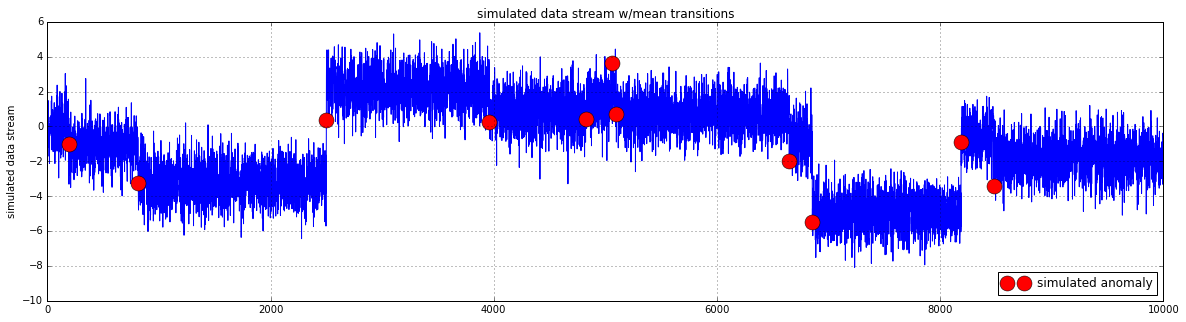

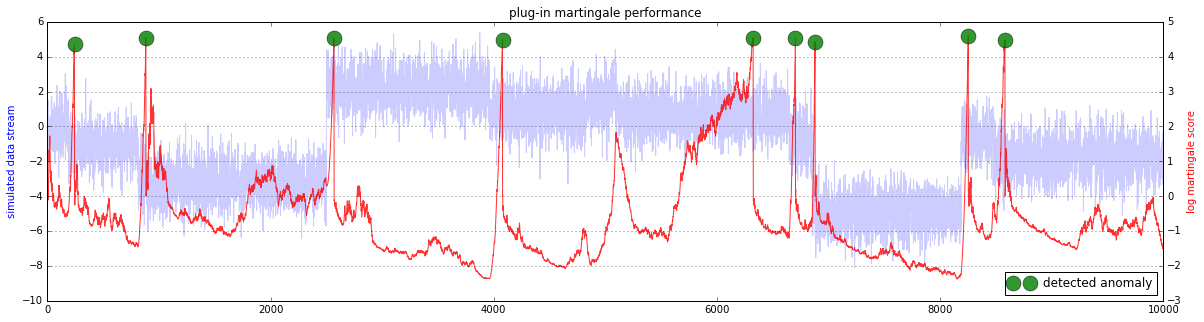

In [11]:
# Test martingale detection with default params
anomalies, m_scores, anom_label, data = test_streaming_martingale(window_len=2000, threshold=100)
plot_sim_martingale_results(anomalies, m_scores, anom_label, data)

We can see above that without much optimization, our model does pretty well out-of-the-box at identifying most anomalies.  It fails to detect events that arrive in close succession, but captures most well-separated events.  It is also worth noting that some of the events are detected, but with a significant delay after their true event time.  This indicates that the parameter values chosen for this example are probably not optimal, they will probably fall outside our extended event windows, and should be tuned to make the model more sensitive.  So we'll go ahead and do that here by sweeping the values of window size and threshold parameters across a broad range.

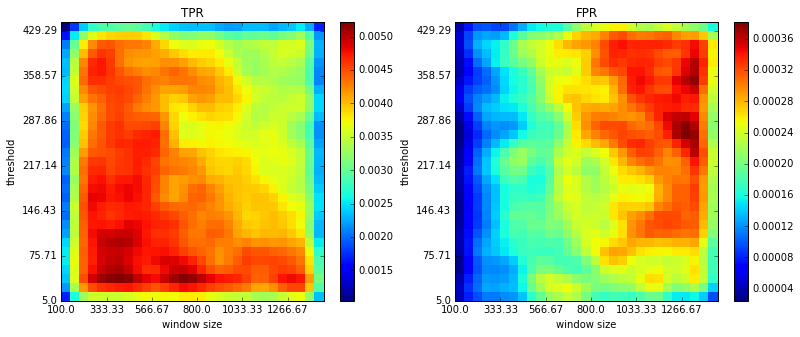

In [13]:
# Run parameter sweep to identify reasonable parameter values for 
# desired performance characteristics

thresh_min=5
thresh_max=500
n_thresh=31
win_min=100
win_max=1500
n_win_sz=29


# -------- WARNING: THIS LINE TAKES 6+hr TO RUN! -------- 
tpr, fpr, acc = tuneAnomParams(thresh_min, thresh_max, n_thresh, win_min, win_max, n_win_sz)


plotAcc = 0 # Whether to plot overall accuracy scores (very noisy, needs heavy averaging)

# Make smoothing kernel
t = 1 - np.abs(np.linspace(-1, 1, 7))
kernel = t.reshape(7, 1) * t.reshape(1, 7)
kernel /= kernel.sum()   # normalize

tpr_smooth = sig.convolve2d(tpr, kernel, mode='same')
fpr_smooth = sig.convolve2d(fpr, kernel, mode='same')

# Plot TPR
ax = plt.figure(figsize=[20,5]).add_subplot(131)
plt.pcolor(tpr_smooth)
plt.title('TPR')
plt.xlabel('window size');plt.ylabel('threshold')
plt.colorbar()
plt.xlim([0,n_win_sz]);plt.ylim([0,n_thresh])
xlabs = ax.get_xticklabels()
ylabs = ax.get_yticklabels()
ax.set_xticklabels(np.around(np.linspace(win_min,win_max,len(xlabs)),2))
ax.set_yticklabels(np.around(np.linspace(thresh_min,thresh_max,len(ylabs)),2))

# Plot FPR
ax = plt.subplot(132)
plt.pcolor(fpr_smooth)
plt.title('FPR')
plt.xlabel('window size');plt.ylabel('threshold')
plt.colorbar()
plt.xlim([0,n_win_sz]);plt.ylim([0,n_thresh])
xlabs = ax.get_xticklabels()
ylabs = ax.get_yticklabels()
ax.set_xticklabels(np.around(np.linspace(win_min,win_max,len(xlabs)),2))
ax.set_yticklabels(np.around(np.linspace(thresh_min,thresh_max,len(ylabs)),2))


# Plot accuracy
if plotAcc == 1:
    t = 1 - np.abs(np.linspace(-1, 1, 5))
    kernel = t.reshape(5, 1) * t.reshape(1, 5)
    kernel /= kernel.sum()   # normalize
    acc_smooth = sig.convolve2d(acc, kernel, mode='same')

    ax = plt.subplot(133)
    plt.pcolor(acc_smooth, vmin=0.83, vmax=0.885)
    plt.title('ACC')
    plt.xlabel('win_sz');plt.ylabel('threshold')
    plt.colorbar()
    plt.xlim([0,n_win_sz]);plt.ylim([0,n_thresh])
    xlabs = ax.get_xticklabels()
    ylabs = ax.get_yticklabels()
    ax.set_xticklabels(np.around(np.linspace(win_min,win_max,len(xlabs)),2))
    ax.set_yticklabels(np.around(np.linspace(thresh_min,thresh_max,len(ylabs)),2))


    # Find best accuracy score
    best_acc_idx = np.unravel_index(acc_smooth.argmax(), (n_thresh, n_win_sz))

    plt.plot(best_acc_idx[0], 0.5 + best_acc_idx[0], marker='*', c='w', ms=20)
    

From the parameter sweep visualizations above, it is apparent that the true positive rate (TPR; left) is highest for low values of both threshold and window size, and decreases as both parameters are increased.  The false positive rate (FPR; right) is affected in a largely opposite manner.  FPR is lowest at lower values for threshold and window size, and increases as both parameters are increased.  This is at first a bit counterintuitive, since we would expect that increasing the martingale threshold for what we consider an "anomaly" would tend to lower the FPR.  But the opposing pattern observed indicates that the relationship between threshold and FPR is not as simple as we might expect.  In fact, we can see evidence that for smaller window sizes ($<600$), FPR seems to be relatively unaffected by the threshold, but at larger window sizes, increases in threshold have a much larger effect.

Overall, these results indicate that low values for both window size (~300) and threshold (~35) strike a good balance between having a high TPR and low FPR.  Therefore, we expect that these may be good baseline parameter values for our model.  We can test this by running some additional simulations with this new set of parameter values and comparing the predicted anomaly times with actual, simulated anomalies, as shown below.  We can see that this model does quite well now at identifying the anomalies in streaming data with these characteristics.

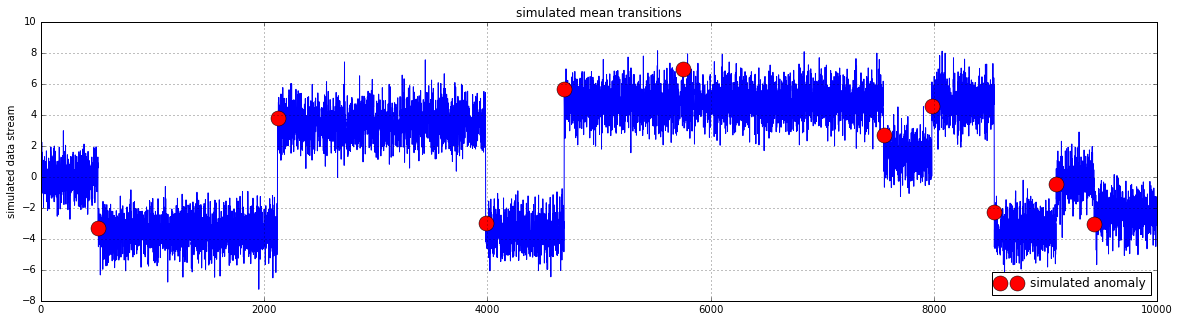

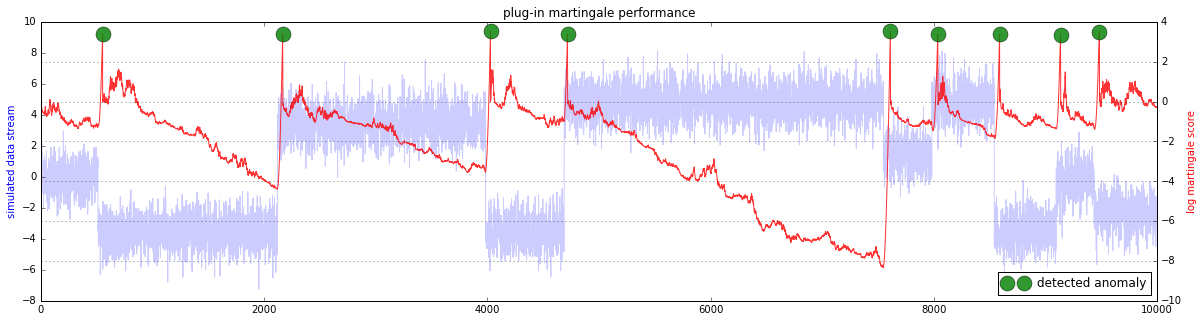

In [22]:
# Test martingale detection with reasonable parameter choices taken from above
anomalies, m_scores, anom_label, data = test_streaming_martingale(window_len=350, threshold=35)
plot_sim_martingale_results(anomalies, m_scores, anom_label, data)

## Next steps
Our next steps will be to evaluate the model under a variety of different experimental conditions using simulation, and test performance on various real-world time series from the Numenta Anomaly Benchmark (NAB) corpus.  We hope to identify the conditions under which our current model fails, and extend the current model to better deal with these different scenarios.  For example, does the model also do well at detecting changes in variance, as opposed to mean, or when the mean shifts are more transient?  Preliminary results seem to indicate that the model performs well when anomalies result in stable baseline shifts, but has trouble detecting transient ($<10$ time steps) deviations.  We can explore the detection limits using simulation and find when performance starts to break down. It is possible that we may need to implement different strangeness functions (e.g. clustering-based distances) or betting functions (e.g. power-series martingales) to better deal with highly transient anomalies, or we may need to develop a hybrid approach utilizing a number of these different approaches.

In addition, we will consider alternative strategies for improving computational efficiency, like changing how streaming data are cached and using more efficient martingale betting functions that do not require the time-intensive process of doing kernel density estimation at every time step.

